# Convolutional Neural Networks

In [1]:
#Imports
import numpy as nplearn_tf
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix

In [2]:
#Preferences
warnings.simplefilter(action="ignore", category=FutureWarning)
%matplotlib inline

### Data Preparation

Images from Kaggle competition: https://www.kaggle.com/c/dogs-vs-cats

In [3]:
# Organize data into train, valid, test dirs
os.chdir("data/dogs-vs-cats")

In [4]:
if os.path.isdir("train/dog") is False:
    os.makedirs("train/dog")
    os.makedirs("train/cat")
    os.makedirs("val/dog")
    os.makedirs("val/cat")
    os.makedirs("test/dog")
    os.makedirs("test/cat")
    
    for c in random.sample(glob.glob("train1/cat*"), 1000):
        shutil.move(c, "train/cat" )
    for c in random.sample(glob.glob("train1/dog*"), 1000):
        shutil.move(c, "train/dog" )
    
    for c in random.sample(glob.glob("train1/cat*"), 500):
        shutil.move(c, "val/cat" )
    for c in random.sample(glob.glob("train1/dog*"), 500):
        shutil.move(c, "val/dog" )
    
    for c in random.sample(glob.glob("train1/cat*"), 100):
        shutil.move(c, "test/cat" )
    for c in random.sample(glob.glob("train1/dog*"), 100):
        shutil.move(c, "test/dog" )

os.chdir("../../")

In [5]:
#path variables
train_path = "data/dogs-vs-cats/train"
val_path = "data/dogs-vs-cats/val"
test_path = "data/dogs-vs-cats/test"

In [6]:
#Creates keras image generator. Applies vgg16 preprocessing to images first.
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
.flow_from_directory(directory=train_path, target_size=(224, 224), classes=["cat", "dog"], batch_size=10)

Found 2000 images belonging to 2 classes.


In [7]:
#Creates keras image generator. Applies vgg16 preprocessing to images first.
val_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
.flow_from_directory(directory=val_path, target_size=(224, 224), classes=["cat", "dog"], batch_size=10)

Found 1000 images belonging to 2 classes.


In [8]:
#Creates keras image generator. Applies vgg16 preprocessing to images first.
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
.flow_from_directory(directory=test_path, target_size=(224, 224), classes=["cat", "dog"], batch_size=10, shuffle=False)

Found 200 images belonging to 2 classes.


In [9]:
#Verifying the correct number of images
assert train_batches.n == 2000
assert val_batches.n == 1000
assert test_batches.n == 200

In [10]:
#Verifying the correct number of classes
assert train_batches.num_classes == val_batches.num_classes == test_batches.num_classes == 2

In [11]:
imgs, labels = next(train_batches)

In [12]:
#Plots images in a grid
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis("off")
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

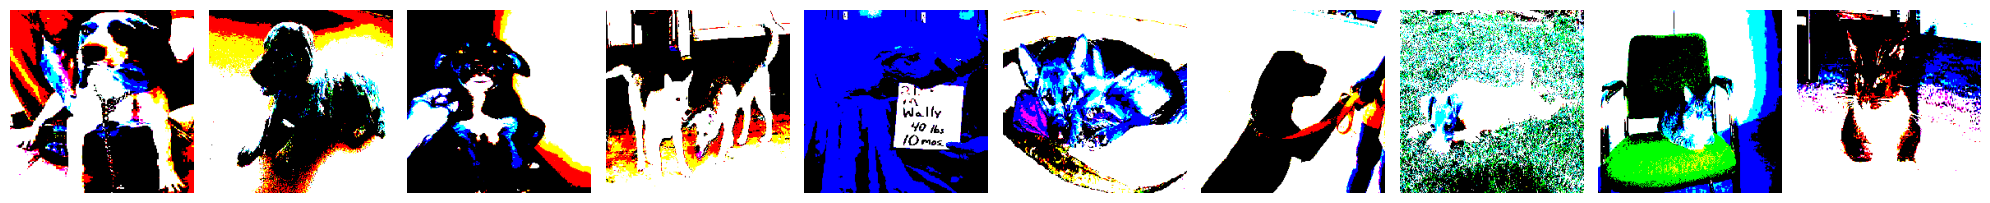

[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]]


In [13]:
#Color looks distorted because of preprocessing
plotImages(imgs)
print(labels)

### Build and Train a CNN

In [14]:
#Remember target_size is the same as input_shape
#Input shape is height, width and colors
model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation="relu", padding = "same", input_shape=(224, 224, 3)),
    MaxPool2D(pool_size=(2,2), strides=2),
    Conv2D(filters=64, kernel_size=(3,3), activation="relu", padding = "same"),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Flatten(),
    Dense(units=2, activation="softmax"),
])

2023-07-22 19:17:22.012834: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 200704)            0         
                                                                 
 dense (Dense)               (None, 2)                 4

In [16]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

In [19]:
model.fit(x=train_batches, validation_data=val_batches, epochs=10, verbose=2)

Epoch 1/10
200/200 - 52s - loss: 10.6590 - accuracy: 0.5815 - val_loss: 2.7627 - val_accuracy: 0.6500 - 52s/epoch - 259ms/step
Epoch 2/10
200/200 - 52s - loss: 1.2074 - accuracy: 0.7870 - val_loss: 2.6352 - val_accuracy: 0.6030 - 52s/epoch - 258ms/step
Epoch 3/10
200/200 - 52s - loss: 0.2263 - accuracy: 0.9245 - val_loss: 1.8770 - val_accuracy: 0.6630 - 52s/epoch - 259ms/step
Epoch 4/10
200/200 - 51s - loss: 0.0584 - accuracy: 0.9845 - val_loss: 1.7165 - val_accuracy: 0.6730 - 51s/epoch - 257ms/step
Epoch 5/10
200/200 - 51s - loss: 0.0073 - accuracy: 0.9995 - val_loss: 1.6802 - val_accuracy: 0.6820 - 51s/epoch - 256ms/step
Epoch 6/10
200/200 - 51s - loss: 0.0028 - accuracy: 1.0000 - val_loss: 1.6994 - val_accuracy: 0.6860 - 51s/epoch - 257ms/step
Epoch 7/10
200/200 - 51s - loss: 0.0020 - accuracy: 1.0000 - val_loss: 1.7103 - val_accuracy: 0.6860 - 51s/epoch - 257ms/step
Epoch 8/10
200/200 - 51s - loss: 0.0016 - accuracy: 1.0000 - val_loss: 1.7218 - val_accuracy: 0.6860 - 51s/epoch - 25

### Predict